# Clustering songs using K-Means Clustering

This notebook uses K-Means clustering to cluster songs from spotify based on their achoustic properties. The original data set comes from [this kaggle repo](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks).

The purpose of this notebook is to show a real world example of using K-Means clustering on a dataset. This being an example notebook, the focus is on displaying some techniques and ways of thinking - rather than getting a great result. The results should serve as a starting point for anyone going through this notebook - feel encouraged to come up with ideas on how to improve them - and experiemnt!

**Within that scope, the declared purpose of this notebook is cluster songs, with the aim of getting clusters that closely match those of "musical genres".**

The indirect purpose of the notebook, and the more relevant one, 

In [2]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from sklearn.metrics import silhouette_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

In [3]:
# Setting random state for reproduciability
RANDOM_STATE = 42

In [4]:
# Read in the data
df = pd.read_csv("./data/raw/tracks.csv")

## Glancing at the dataset
Before diving into the clustering, it's always a good idea to take a look at the dataset.

In [5]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


In [6]:
df.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586672.000000,5.866720e+05,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000,586672.000000
mean,27.570053,2.300512e+05,0.044086,0.563594,0.542036,5.221603,-10.206067,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464857,3.873382
std,18.370642,1.265261e+05,0.205286,0.166103,0.251923,3.519423,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764108,0.473162
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [7]:
df.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

* Nominal data (e.g. artists)
* Binary data (e.g. explicit)
* Different scales (e.g. loudness)

_________
## Sampling
To run things faster, we'll be taking a random sample of the dataset: randomally picking 20% of it.

Feel free to later rerun this notebook without this sampling, and compare the results. Think about if and how you expect the results to change, and which paramters you might alter in the process accordingly.

In [8]:
df_sample = df.sample(frac=0.2, random_state=RANDOM_STATE)

In [9]:
df_sample.shape

(117334, 20)

__________
### Feature Selection
Feature selection is a crucial part of the pipeline. How do we decide which data stays in and which does not?

The reasons could come from at leaset the following two aspects:
* Data type: Kmeans deals with eucleadian distance, and so it is best suited for continous numerical data.
* Meaning: In this specfic case, we have some information about what we are looking for - some proxy for genres. So we might make a judgement call that 'release_date' should be excluded, reasoning that it is not a good proxy.

In this case, simply keeping float type data, gives us a good place to start, and seems to leave us with information regarding the song's achoustic properties only.

More details about the features can be found here: https://developer.spotify.com/documentation/web-api/reference/#object-audiofeaturesobject

In [10]:
# Take only float data
X = df_sample.select_dtypes("float")
X.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
241517,0.890,0.6680,-10.044,0.0533,0.570,0.000002,0.0591,0.942,137.934
444213,0.663,0.5510,-6.445,0.0280,0.697,0.000000,0.1800,0.339,128.992
106480,0.376,0.0979,-18.280,0.0350,0.485,0.000577,0.1150,0.236,90.290
141137,0.565,0.3270,-13.843,0.0295,0.781,0.000011,0.1310,0.556,103.256
586550,0.582,0.9790,-2.492,0.0714,0.125,0.001520,0.3390,0.196,128.010


______
### Preprocessing
It's important to to normalize our features - so that a feature with a larger scale - such as "loudness", would not overweigh a smaller scale feature, such as "energy". That is easily achieved using one of scikit learn's Scalers - here we use StandardScaler, and its results are neatly visisble below, where all min values are 0 and mac values are 1. Note that for K-Means clustering, the type of scaler is not crucial - StandardScaler would have done the same job, in a different way.

In [11]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pd.DataFrame(X_scaled, columns=X.columns).describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1.173340e+05,1.173340e+05,1.173340e+05,1.173340e+05,1.173340e+05,1.173340e+05,1.173340e+05,1.173340e+05,1.173340e+05
mean,-5.886773e-16,1.842152e-16,-4.893028e-16,-5.577325e-17,-1.343160e-16,-4.305622e-17,2.149178e-16,8.163121e-17,1.620815e-16
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-3.389332e+00,-2.153287e+00,-9.781128e+00,-5.839615e-01,-1.287502e+00,-4.253720e-01,-1.162025e+00,-2.142795e+00,-3.977413e+00
25%,-6.695375e-01,-7.841742e-01,-5.281120e-01,-3.931844e-01,-1.013340e+00,-4.253720e-01,-6.269882e-01,-8.001625e-01,-7.687073e-01
50%,8.261816e-02,2.538850e-02,1.907901e-01,-3.353902e-01,-7.728823e-02,-4.252796e-01,-4.101403e-01,4.577338e-02,-3.473200e-02
75%,7.384979e-01,8.151089e-01,7.311451e-01,-1.580797e-01,9.579895e-01,-3.905678e-01,3.471927e-01,8.412636e-01,6.031982e-01
max,2.555706e+00,1.815157e+00,2.904547e+00,4.864407e+00,1.568832e+00,3.329129e+00,4.275517e+00,1.737645e+00,4.287936e+00


____
## Selecting the number of clusters
Selecting the amount of clusters is the most crucial decision you make when working with a K-Means clustering algorithm. Therefore, we want to make an informed decision (as far as possible). Again, a combination of "real world knowledge" and statistics is best.

"The real world", means you might have some apriori knowledge about the what these clusters might represent. In our case we'd like them to match song genres, which means we can expect K as being anywehere between 10 and 50.

However, that's already a large range, as we want to pick just a single K. Additionaly, this being **unsupervised ML** - we often have no real idea what we might be searching for. To assist our decision, what we actually do is iterate on a range of K's, and compare some metric to help us decide.

One way to go about it is called the "Elbow Method". That means we plot that metric against K, and look for the "knee" of that graph - we'll see that below in a bit.

So what should that metric be? There are a couple of options, and we will go with the simplest one - "inertia". If you recall, inertia is what the K-Means algorithm aims to minimize, and in simple terms it demonstrates how "grouped" (or "coherent") a cluster is.

More sophisticated selections methods could be using the "Silhouette score" or the "Calinski Harabasz Score" (go ahead and google it if you're curious!)

See sklearn's documentation about [clustering evaluation.](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)

### The elbow method
The elbow method is a simple way to visualize where our gain from adding clusters stops becoming significant. Generally, more clusters mean a more complicated model, and we should always strive for simplicity if we can.

**NOTE** - we use `MiniBatchKMeans` here, and not the standard `KMeans` - once again, this saves us time for large datasets, with relatively low risk. See [this](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html) for a comparison of the two.

In [12]:
# We fit the model on the data using multiple K's, and store the inertia from each fitting.
inertias = [] 
K = range(1, 50)
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE).fit(X_scaled)
    inertias.append(kmeans.inertia_)

Text(0.5, 1.0, 'Inertia Elbow Method')

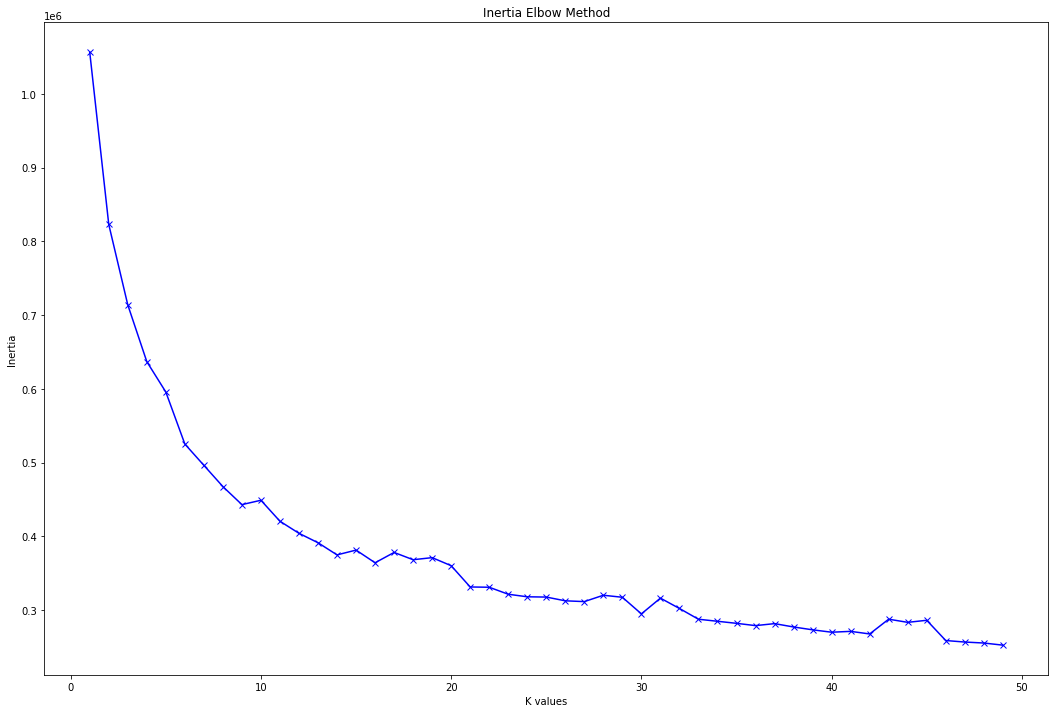

In [13]:
fig = plt.figure(figsize=(18,12))
plt.plot(K, inertias, 'bx-')
plt.xlabel("K values")
plt.ylabel("Inertia")
plt.title("Inertia Elbow Method")

Judging where the "elbow" is isn't entirely objective, and in reality you should experiment with a range of values also when moving forward.

For our purposes, let's go ahead with K=15.

_______
### Clusteirng to 15 clusters

In [14]:
N_CLUSTERS = 15

In [15]:
kmeans = MiniBatchKMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE).fit(X_scaled)

In [16]:
clusters = kmeans.predict(X_scaled)
#This is similar to running clusters=kmeans.labels_ -> Can you see why?

____
### Measuring performance

* Model evalaution
* Create our own metric

### Model evaluation

One way to evaluate the results, is by scoring the model itself - are actually getting what we expect to get from the algorithm - namely, separated, clustered groups?

There are various ways to do that, and we go for Inertia (remeber what inertia is?) and add the Silhouette score, as it has the following advantages in describing the results:

* The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
* The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster. [(source)](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

You can find [different evaluation metrics here](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

In [17]:
inertia = kmeans.inertia_

In [18]:
s_score = silhouette_score(X_scaled, clusters)

In [31]:
print(f"Inertia score:    {inertia:.3f}")
print(f"Silhouette score: {s_score:.3f}")

Inertia score:    381528.990
Silhouette score: 0.142


Note that while the silhouette score does give some objective information about how good the model behaves, the inertia score is only a comparative measure for more iterations - it is sensitive to the scale of the paramters, how many dimensions are there, how large the dataset is, etc. 

### Creating our own metric

Note how the inertia and silhouette score only provides information about how "neat" the clusters are. But not much information about what they mean. An ideal case would be if we would have truth labels to compare to. In this case we might turn to other data in the kaggle dataset that **does** contain the genres - and compare it to that.

But let's try to be creative with this dataset, and work our own metric.

In [20]:
df_sample["cluster"] = clusters

In [21]:
df_sample.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster
241517,0rTUAMd7huYjda84aceuzl,Дети проходных дворов,21,105015,0,['Kino'],['2jkl2xJVm71azWAgZKyf42'],1985-01-01,0.890,0.6680,...,-10.044,0,0.0533,0.570,0.000002,0.0591,0.942,137.934,4,13
444213,4bMy8NjgkVHize43OSrChu,95,37,234800,0,['Picture This'],['7jLSEPYCYQ5ssWU3BICqrW'],2017-08-25,0.663,0.5510,...,-6.445,1,0.0280,0.697,0.000000,0.1800,0.339,128.992,4,8
106480,4X1xn2bjxlaLbx6o3jSEXj,As almal ver is,10,147733,0,['Koos Du Plessis'],['4utxbudXUuseiCfVJ0B2xM'],1992,0.376,0.0979,...,-18.280,1,0.0350,0.485,0.000577,0.1150,0.236,90.290,3,2
141137,3ZwzDf7V1xlAS9WWuviqIm,"Il tuo mondo (Nono, dobri moj nono)",29,194373,0,['Claudio Villa'],['2r4iOKmxTQU9s361Yt3gq1'],1969,0.565,0.3270,...,-13.843,1,0.0295,0.781,0.000011,0.1310,0.556,103.256,3,3
586550,712Hktc9DnU5u9uOSn1q1Y,Bazaar - Official Sunburn Goa 2015 Anthem,55,172500,0,"['KSHMR', 'Marnik']","['2wX6xSig4Rig5kZU6ePlWe', '6S3KljEiIOWoLMUyZr...",2015-12-25,0.582,0.9790,...,-2.492,0,0.0714,0.125,0.001520,0.3390,0.196,128.010,4,1


Adding the outputted labels (=clusters) of each song back to the original df, allows us to consider the following: if this **is** a genre proxy, what do we expect of it?

Well, for one thing, we might expect a single artist to create, for the most part, the same type of genre-songs.

Let's group by artits, then, and count the number of unique clusters each artist contains. Finally, we'll use that `n_clusters` feature as our metric - we'd like it to be as close to 1 as possible.

In [22]:
gp = df_sample.groupby("artists").agg({"id": "count", "cluster": "nunique"}).reset_index()
gp = gp.rename(columns={"cluster": "n_clusters", "id": "n_songs"})

In [23]:
score, std = gp.n_clusters.mean(), gp.n_clusters.std()

In [ ]:
print(f"n_clusters score:     {score:2f}")
print(f"n_clusters score std: {std:2f}")

**Hey, that's pretty good!**

.


.

hmmm....

.

.

In [25]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="https://i.redd.it/ftgwjwxhlpz01.jpg")

Let's take a look at our grouped dataset. Notice that `n_clusters=1` seems to be go hand in hand with `n_songs=1`.

In [26]:
gp.sort_values("n_clusters").head(10)

,artists,n_songs,n_clusters
0,"[""'In The Heights' Original Broadway Company"",...",1,1
26313,"['Miliyah', 'Wakadanna']",1,1
26312,['Militärmusik Tirol'],1,1
26310,"['Milion Plus', 'Yzomandias', 'Hasan', 'Nik Te...",1,1
26309,"['Milion Plus', 'Nik Tendo', 'Kamil Hoffmann',...",1,1
26308,['Milind Ingle'],1,1
26307,"['Miligram', 'Aden Ademovic']",1,1
26306,"['Milica Todorovic', 'MC Yankoo']",1,1
26305,['Mili'],2,1
26303,"['Miley Cyrus', 'Stevie Nicks']",1,1


Not only that, but more then half of the artists only have a single song - and therfore a single cluster.

In [27]:
print(f'Ratio of single-hit wonders: {round(gp[gp["n_songs"]==1]["n_songs"].count() / gp.shape[0], 2)}')

Ratio of single-hit wonders: 0.64


So, let's take only artists with at least 10 songs, and recalcluate:

In [29]:
gp = gp[gp["n_songs"]>10]
score, std = gp.n_clusters.mean(), gp.n_clusters.std()
print(f"n_clusters score:     {score:2f}")
print(f"n_clusters score std: {std:2f}")

n_clusters score:     5.851628
n_clusters score std: 2.139309


Not as good - but that makes sense, considering our silhouette score - still room to improve.

To make things more visual, we can plot the distribution of `n_clusters`.

Here we are using the excellent [Altair](https://altair-viz.github.io/index.html) library - which is a visualization library for declarative visualization, using a "grammar of graphics" syntax.

In [360]:
alt.Chart(gp).mark_bar().encode(
    x=alt.X("n_clusters", bin=alt.Bin(step=1)),
    y='count()'
)

alt.Chart(...)

A nice gaussian distribution is a good signal that our metric is at least somewhat reasonable to use!

____
## Possible future directions

This notebook shows a basic usage of the K-means algorithms. To take it further, we might consider several routes:

* Looking into the best and worst cases - which artists got the least and most amount of clusters, and analyzing these cases:

In [361]:
gp.sort_values("n_clusters", ascending=False)

,artists,n_songs,n_clusters
26299,['Miles Davis'],97,14
8860,['David Bowie'],75,14
37639,['The Rolling Stones'],128,14
37451,['The Moody Blues'],31,14
12403,['Fleetwood Mac'],92,14
...,...,...,...
13809,"['Georgette Heyer', 'Irina Salkow']",82,1
15239,['H.P. Lovecraft'],41,1
25474,"['Maurice Ravel', 'Robert Casadesus']",12,1
36299,['Tadeusz Dolega Mostowicz'],156,1


* Improving our metrics: normalizing `n_clusters` to `n_songs`, or taking into account the time between the `min(release_date)` and `max(release_date)` seems appropriate
* Tinkering with the algorithm's parameters - amount of clusters, to start with!